<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
import re
%matplotlib inline
from matplotlib import pyplot as plt


In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
#Скользящее окно
def sliding_window(arr, window_size, step=1, placeholder=0):
    n_obs = arr.shape[0]
    
    n_windows = n_obs // step
    if (n_obs % step) > 0:
        n_windows += 1
    
    if n_obs < (n_windows * window_size):
        arr = np.pad(arr, (0,n_windows * window_size-n_obs), 'constant', constant_values=(0, placeholder)) 
        n_obs = n_windows*window_size
    
    
    #print(n_windows)

    obs_stride = arr.strides[0]
    windowed_row_stride = obs_stride * step

    new_shape = (n_windows, window_size) + arr.shape[1:]
    new_strides = (windowed_row_stride, ) + arr.strides

    strided = np.lib.stride_tricks.as_strided(
        arr,
        shape=new_shape,
        strides=new_strides,
    )
    return strided


In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    full_f_names = glob(path_to_csv_files+'/*.csv')
    
    with open(site_freq_path,"rb") as pickle_in:
        dct = pickle.load(pickle_in)
        
    df = pd.DataFrame(columns=feature_names)

    
    for filename in full_f_names:
        
        user_id = int(re.search(u'([0-9]+)\.csv$',filename).group(1))
        
        u_sites = []
        u_times = []
        with open(filename, 'r') as f:
            for line in f.readlines()[1:]:
                time, site = line.strip().split(',')
                u_sites.append(dct[site][0])
                u_times.append(np.datetime64(time))
        u_times = sliding_window(np.array(u_times), session_length, window_size, u_times[-1])
        u_difs = (u_times[:,1:]-u_times[:,:-1]).astype(int)
        
        u_timespans = np.sum(u_difs, axis = 1)
        u_start_dts = pd.DataFrame(u_times[:,0], columns=['d'])
        u_start_hours = u_start_dts.d.dt.hour.values
        u_days_of_week = u_start_dts.d.dt.dayofweek.values
       
        u_sites = sliding_window(np.array(u_sites), session_length, window_size, 0)
        u_uniqs = np.array([len(np.unique(x[x > 0])) for x in u_sites])
        u_targets = np.full(u_uniqs.shape[0], user_id)
        
        df = df.append( pd.DataFrame(
                np.column_stack((u_sites,
                           u_difs,
                           u_timespans,
                           u_uniqs,
                           u_start_hours,
                           u_days_of_week,
                           u_targets                         
                            ))
                ,columns = feature_names            
            ), ignore_index = True)
        
    
    return df

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [6]:
train_data_toy

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10 time_diff1  \
0     3     2     2     7     2     1     8     5     9     10        287   
1     3     1     1     1     0     0     0     0     0      0          2   
2     3     2     6     6     2     0     0     0     0      0        287   
3     4     1     2     1     2     1     1     5    11      4        287   
4     4     1     2     0     0     0     0     0     0      0        287   

  time_diff2 time_diff3 time_diff4 time_diff5 time_diff6 time_diff7  \
0       1184       6278        186          2          1          2   
1          3         55          0          0          0          0   
2       1184       6278        186          0          0          0   
3       1184       6278        186          2          1          2   
4       1184          0          0          0          0          0   

  time_diff8 time_diff9 session_timespan #unique_sites start_hour day_of_week  \
0          3         55             7998             8          9           4   
1          0          0               60             2         12           4   
2          0          0             7935             3          9           4   
3          3         55             7998             5          9           4   
4          0          0             1471             3         12           4   

  target  
0      1  
1      1  
2      2  
3      3  
4      3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
#%%time
#Почему-то когда включен %%time не происходит присвоение значения (глюк)
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [8]:
train_data_10users.head()

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10 time_diff1  \
0   193   581   134     3   134   134     3   134   204    134         10   
1   415   192   690   254   134    31   400  3857   219     55          1   
2    55     3    55    55     5   294   415   336   920     55          0   
3   479  3858   479    55    55    55    55   953   200    123          2   
4   343    55     5  3859   259   212  3860  2345   691   2345          1   

  time_diff2 time_diff3 time_diff4 time_diff5 time_diff6 time_diff7  \
0          0          0          1         20          1          0   
1          0        163        105          0          1          3   
2         14          1        242          0          0          1   
3          1          0          1         25          1          0   
4          0          1          1          1          0          1   

  time_diff8 time_diff9 session_timespan #unique_sites start_hour day_of_week  \
0          1          0               33             5          8           4   
1          3          8              284            10          8           4   
2          0          0              258             7          8           4   
3          0          0               30             6          8           4   
4          1          0                6             9          8           4   

  target  
0     31  
1     31  
2     31  
3     31  
4     31

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [9]:
#%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

train_data_150users.head(10)

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10 time_diff1  \
0     1     1     4     2     1     4     1     2  1297    322          1   
1     2    23  1512  1297   322   322   113    73    49     49          0   
2   322   205     1     1     1     1    73   322     2      1          1   
3     1     1  7272  7272  5597  7272  7272     1    35      1          1   
4     1     1    76     1    58    50    58    50    83     76          4   
5    50    58    94    92    50    76    76    83    92     50          0   
6    58    94    58    92    76    83    50    94    94     76          0   
7    83    50    58    92    58    94    50    50    76     58          0   
8    94    76    83    50    92    58  7272    76    50     58          0   
9    94    92    76    58    50    92    94    50    58     83          0   

  time_diff2 time_diff3 time_diff4 time_diff5 time_diff6 time_diff7  \
0          1          1          4          0          1          0   
1          0         26          1         10         73          0   
2         10          1          5         16         56       1917   
3          0          1          0        118        420       1460   
4          3          0          1          0          1          0   
5          1          0          0          0          1          0   
6          6          0          0          0          0          0   
7          0          0          1          0          0          7   
8          0          0          0          0        833          1   
9          0          0          0          1          0          0   

  time_diff8 time_diff9 session_timespan #unique_sites start_hour day_of_week  \
0         49          0               57             5          8           4   
1       1504          4             1618             8          8           4   
2          0          4             2010             5          8           4   
3          6          0             2006             4          9           4   
4          1          0               10             5          9           4   
5          0          0                2             6          9           4   
6          1          0                7             6          9           4   
7          0          1                9             6          9           4   
8          1          0              835             7          9           4   
9          0          0                1             6          9           4   

  target  
0      6  
1      6  
2      6  
3      6  
4      6  
5      6  
6      6  
7      6  
8      6  
9      6

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [12]:
new_features_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [13]:
new_features_10users.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [14]:
new_features_150users.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [15]:
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [16]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [17]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

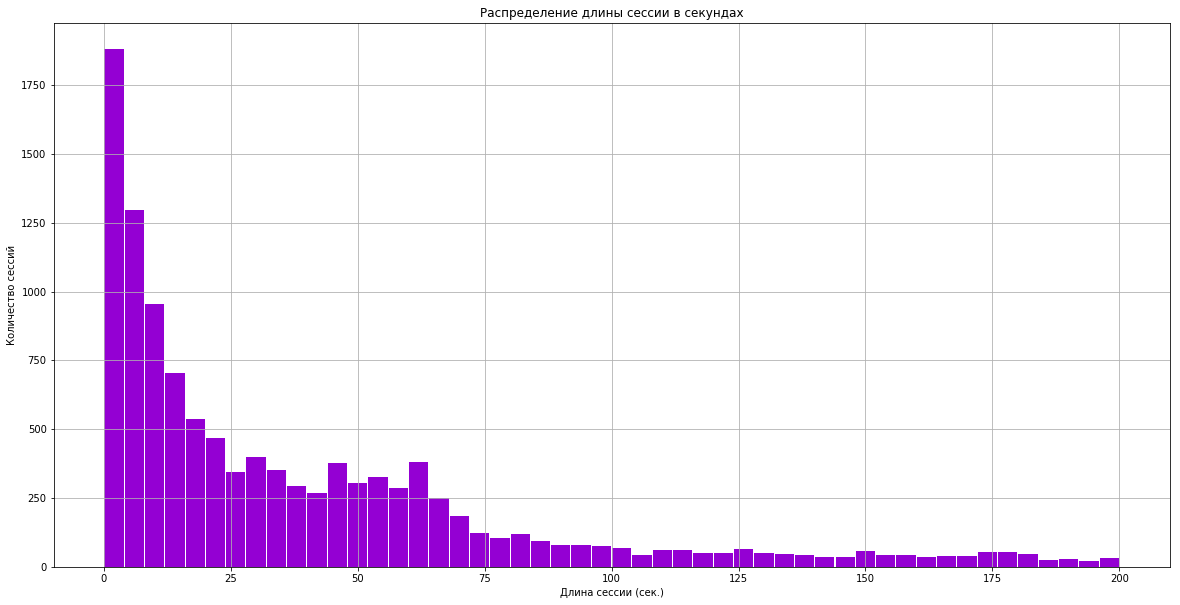

In [18]:
train_data_10users['session_timespan'][train_data_10users.session_timespan <= 200].astype(float).hist(
                                    figsize=(20,10),
                                    bins=50,
                                    color='darkviolet',
                                    rwidth=0.95
                                )
plt.xlabel(u'Длина сессии (сек.)')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение длины сессии в секундах')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

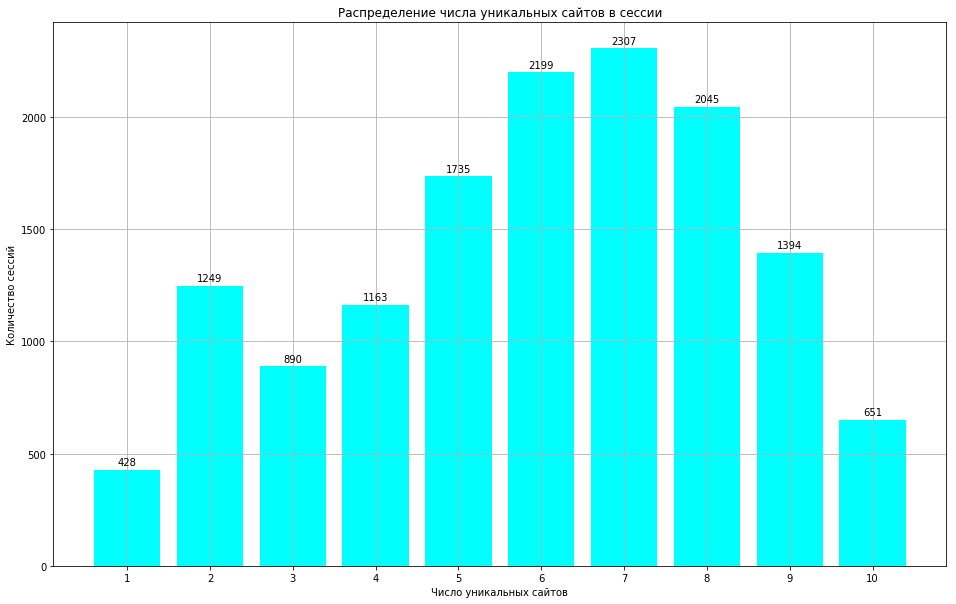

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
hst = np.histogram(train_data_10users['#unique_sites'], bins=range(1,12))
sites = range(1,11)
y_pos = np.arange(1,11)
plt.bar(y_pos, hst[0], align='center', color='aqua')
plt.xticks(y_pos, sites)
plt.xlabel(u'Число уникальных сайтов')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение числа уникальных сайтов в сессии')
plt.grid()
for index, val in enumerate(hst[0]):
    plt.text(index+1, val+20, val, color='black', ha="center")
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

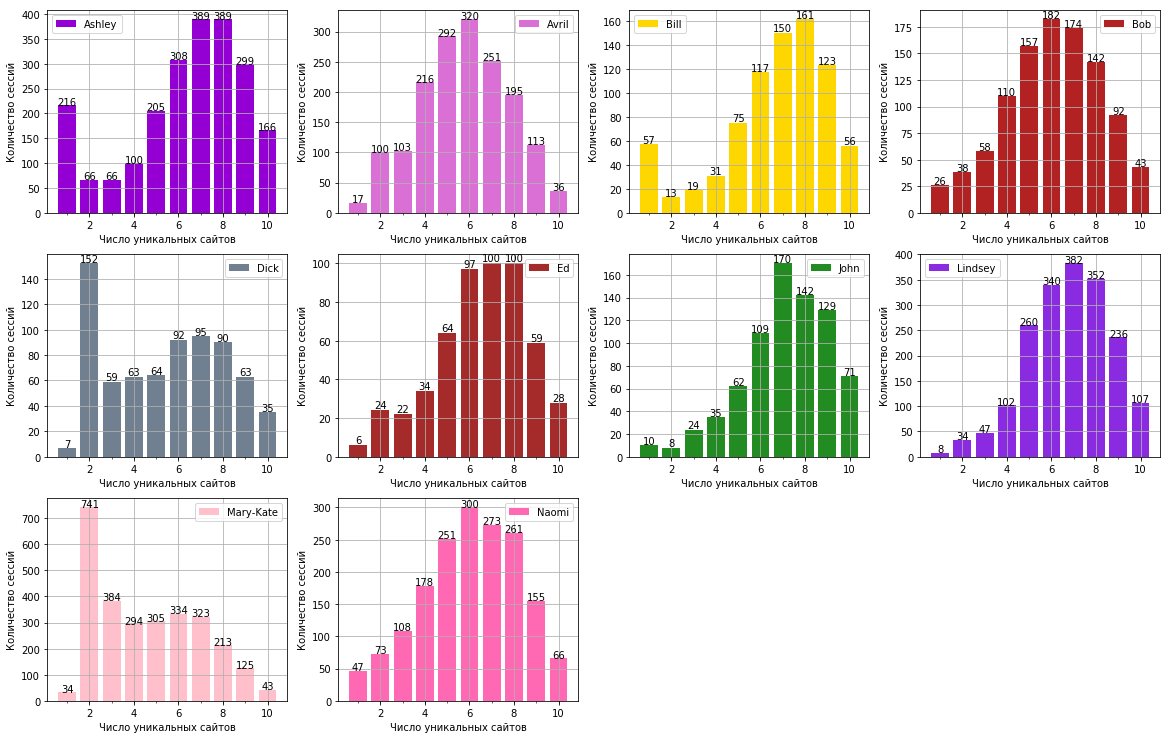

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(pad=0.4, w_pad=2., h_pad=2.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')

# как вариант, можно и по-другому
sites = range(1,11)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    row = idx//4
    col = idx%4
    ax = axes[row][col]
    
    hst = np.histogram(sub_df['#unique_sites'], bins=range(1,12))
    
    y_pos = np.arange(1,11)
    
    ax.bar(y_pos, hst[0], align='center',  color=color_dic[user], label=user)
    ax.set_xticks(y_pos, sites)
    
    ax.set_xlabel(u'Число уникальных сайтов')
    ax.set_ylabel(u'Количество сессий')
    ax.legend()
    for index, val in enumerate(hst[0]):
        if(val > 0):
            ax.text(index+1, val+1, val, color='black', ha="center")
    ax.grid()
    
    

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

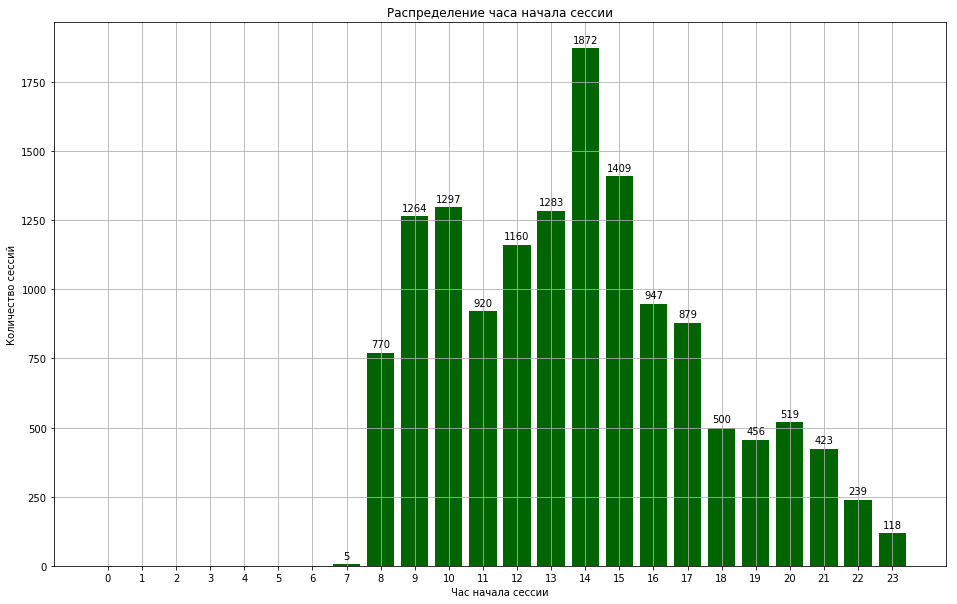

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
hst = np.histogram(train_data_10users['start_hour'], bins=range(0,25))
hours = range(0,24)
y_pos = np.arange(0,24)
plt.bar(y_pos, hst[0], align='center', color='darkgreen')
plt.xticks(y_pos, hours)
plt.xlabel(u'Час начала сессии')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение часа начала сессии')
plt.grid()
for index, val in enumerate(hst[0]):
    if(val > 0):
        plt.text(index, val+20, val, color='black', ha="center")
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

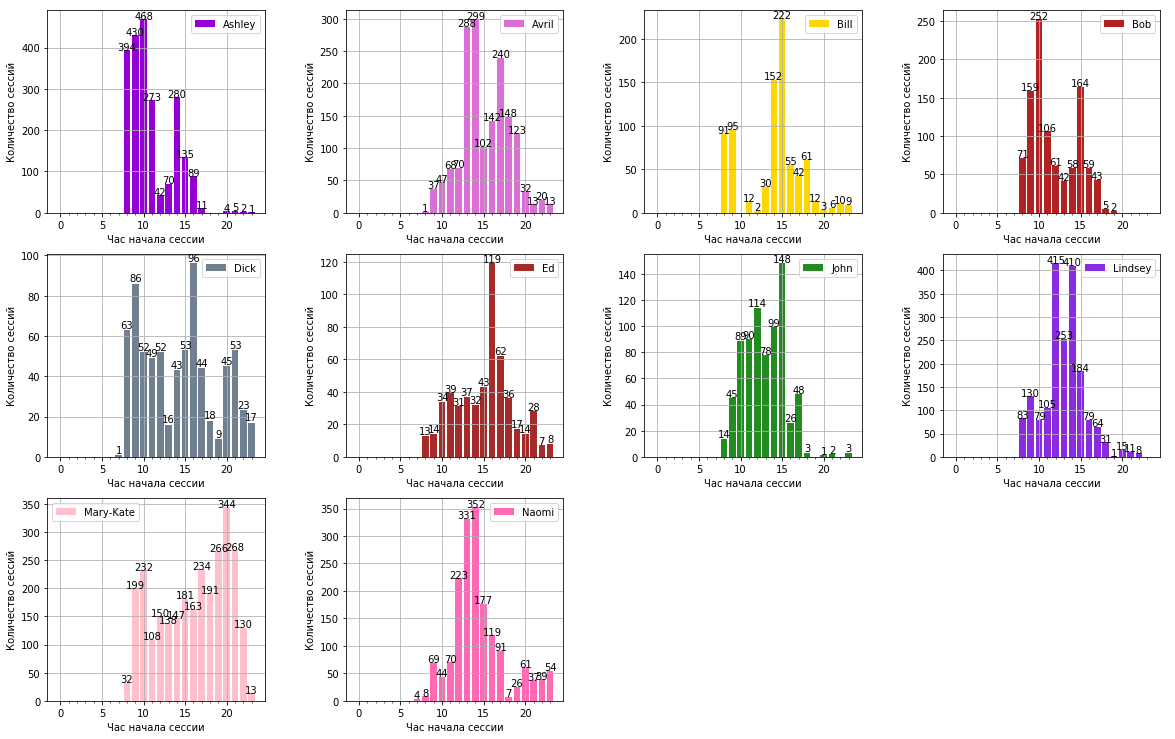

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(pad=0.4, w_pad=5., h_pad=2.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')
# как вариант, можно и по-другому
hours = range(0,24)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    row = idx//4
    col = idx%4
    ax = axes[row][col]
    
    hst = np.histogram(sub_df['start_hour'], bins=range(0,25))
    
    y_pos = np.arange(0,24)
    
    ax.bar(y_pos, hst[0], align='center',  color=color_dic[user], label=user)
   
    ax.set_xticks(y_pos, hours)

    
    ax.set_xlabel(u'Час начала сессии')
    ax.set_ylabel(u'Количество сессий')
    for index, val in enumerate(hst[0]):
        if(val > 0):
            ax.text(index, val+1, val, color='black', ha="center")
    ax.legend()
    
    ax.grid()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

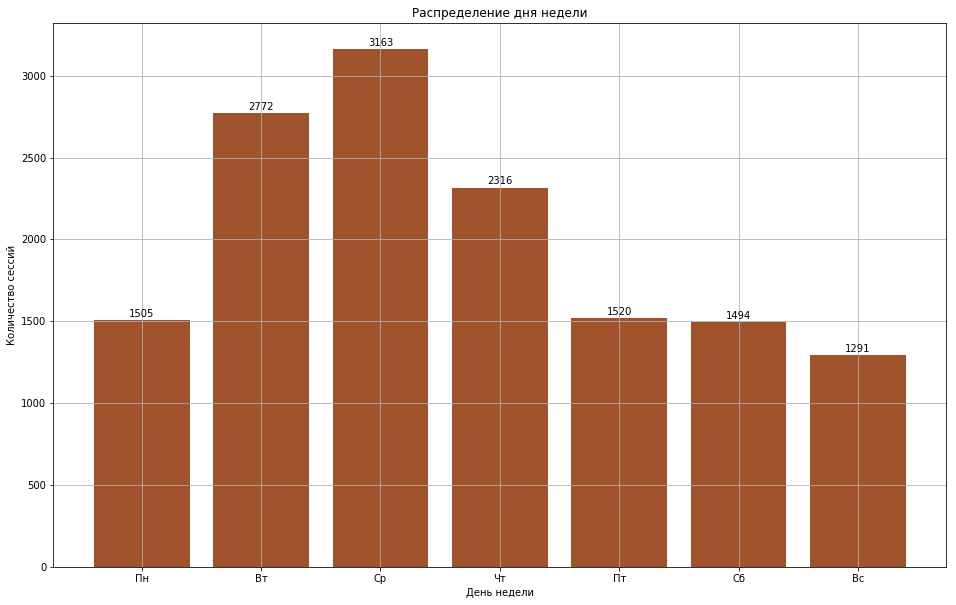

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
hst = np.histogram(train_data_10users['day_of_week'], bins=range(0,8))

days = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']
y_pos = np.arange(len(hst[0]))
plt.bar(y_pos, hst[0], align='center', color='sienna')

for index, val in enumerate(hst[0]):
    plt.text(index, val+20, val, color='black', ha="center")

plt.xticks(y_pos, days)
plt.xlabel(u'День недели')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение дня недели')
plt.grid()
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

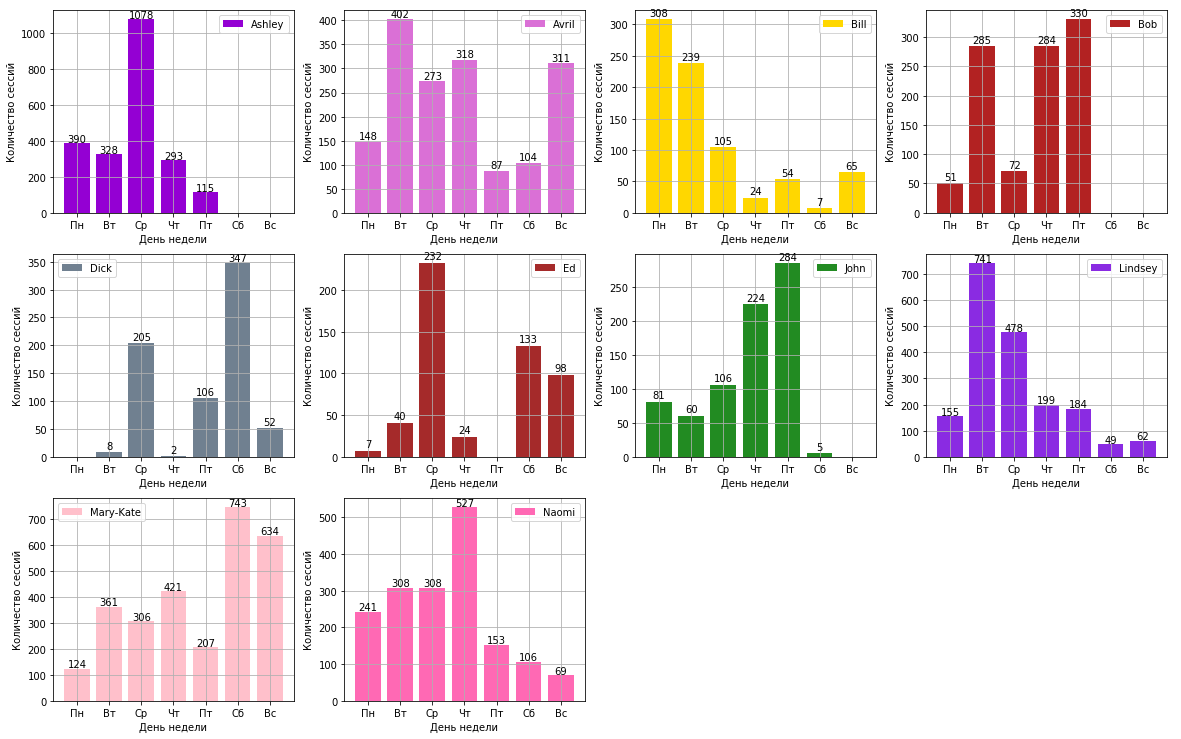

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(pad=0.4, w_pad=2., h_pad=2.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')
days = [0, u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

# как вариант, можно и по-другому

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    row = idx//4
    col = idx%4
    ax = axes[row][col]
    
    hst = np.histogram(sub_df['day_of_week'], bins=range(0,8))
    
    y_pos = np.arange(len(hst[0]))
    
    ax.bar(y_pos, hst[0], align='center',  color=color_dic[user], label=user)
    ax.set_xticklabels(days)
    ax.set_xlabel(u'День недели')
    ax.set_ylabel(u'Количество сессий')
    ax.legend()
    for index, val in enumerate(hst[0]):
        if(val > 0):
            ax.text(index, val+5, val, color='black', ha="center")
    
    ax.grid()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

* В системе в основном наблюдаются короткий по времени сессии (до 30 сек.)
* Максимальное количество уникальных сайтов в сессии - 7, при этом наблюдается локальный максимум 2
* Глобавльный максимум уникальных сайтов на общей диаграмме совпадает с максимумом пользователей Ashley, Avril, Bill, Bob, Ed, John, Lindsey, Naomi
* Вклад на локальный максимум уникальных сайтов на главной диаграмме дают пользователи Ashley, Bill, Dick, Mary-Kate, при чем для пользователей Dick, Mary-Kate эти максимумы являются глобальными
* Общая активность пользователей по времени суток начинается в районе 8 часов утра, заканчивается периодом с 23-до 00 часов, пики активности наблюдаются с 9 до 10 часов, с 14-до 15 часов (главный пик), с 19-до 21 часа
* По пользователям активность по времени суток выглядит слеедующим образом:

|Пользователь|Пики автивности по времени суток| 
|------|------|
|Ashley|с 8 до 12, с 14 до 15|
|Avril|с 13 до 15|
|Bill|с 8 до 10, с 14 до 16| 
|Bob|с 10 до 11, с 15 до 16|
|Dick|с 9 до 10, с 15 до 16, с 20 до 22|
|Ed|с 17 до 18|
|John|с 12 до 13,  с 15 до 16|
|Lindsey|с 12 до 15|
|Mary-Kate|с 19 до 11, с 20 до 21|
|Naomi|с 13 до 15|

* По дням недели общая пик активности приходится на среду
* По пользователям активность по дням недели сведена в таблицу

|Пользователь	|Активен по дням	|Неактивен по дням	|Пики актиности по дням|
|---|---|---|---|
|Ashley	|с Пн. по Пт.|	Сб.,Вс.|	Ср.|
Avril	|с Пн. по Вс.|	-	|Вт.,Вс.
Bill	|с Пн. по Вс.|	-	|Пн.
Bob	|с Пн. по Пт.|	Сб.,Вс.	|Вт.,Чт.,Пт.
Dick	|c Вт. по Вс.|	Пн.	|Ср., Сб.
Ed	|с Пн. по Чт., c Сб по Вс.|	Пт.|Ср., Сб.
John	|с Пн. по Пт. (Сб.??)|	Сб.,Вс.|	Пт.
Lindsey	|с Пн. по Вс.|	-	|Вт
Mary-Kate	|с Пн. по Вс.|	-	|Чт., Сб.,
Naomi	|с Пн. по Вс.|	-	|Чт.


**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [25]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'),"rb") as pickle_in:
        dct = pickle.load(pickle_in)

In [26]:
mydf = pd.DataFrame(dct).T
mydf.reset_index(inplace=True)
mydf.columns = ['site','rank','freq']
mydf.head(10)

site  rank  freq
0                         s.youtube.com     1  8300
1                         www.google.fr     2  7813
2                        www.google.com     3  5441
3                       mail.google.com     4  4158
4                      www.facebook.com     5  4141
5                       apis.google.com     6  3758
6  r3---sn-gxo5uxg-jqbe.googlevideo.com     7  3244
7  r1---sn-gxo5uxg-jqbe.googlevideo.com     8  3094
8                       plus.google.com     9  2630
9                   accounts.google.com    10  2089

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
top10_freqs = mydf['freq'][mydf['rank'] <= 10].values
top10_sites = mydf['site'][mydf['rank'] <= 10].values

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

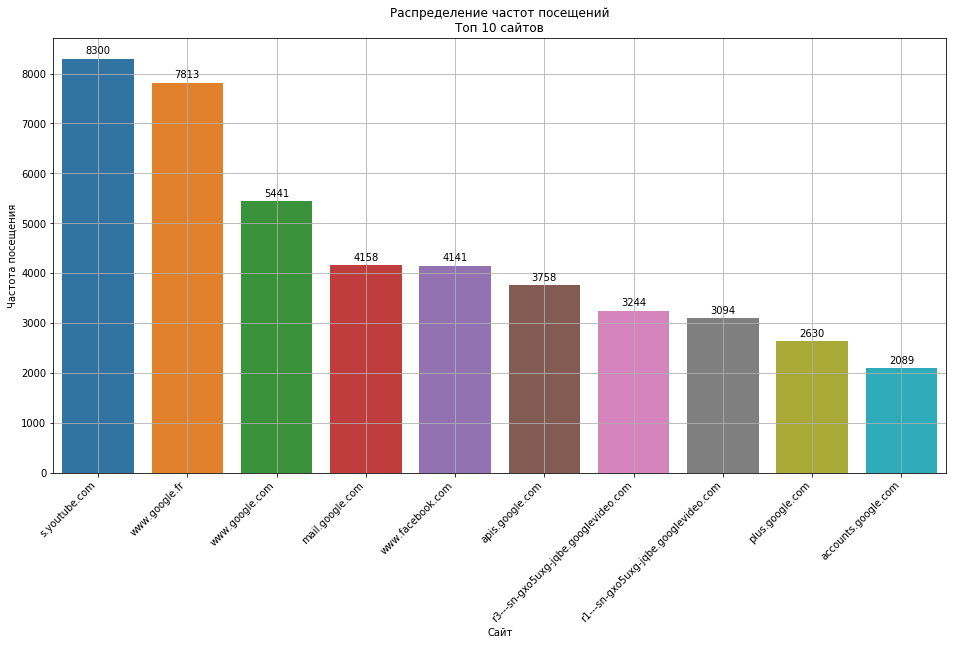

In [28]:
fig, ax = plt.subplots(figsize=(16,8))
g = sns.barplot(data=[[i] for i in top10_freqs], ax=ax)
ax.grid()
ax.set_xticklabels(top10_sites, rotation=45, ha="right")
ax.set_title(u'Распределение частот посещений\nТоп 10 сайтов')
ax.set_xlabel(u'Сайт')
ax.set_ylabel(u'Частота посещения')

for index, val in enumerate(top10_freqs):
    g.text(index, val+100, val, color='black', ha="center")

plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

В нвчале раширим полученную ранее функцию, prepare_train_set_with_fe, будем сохранять имена сайтов и дату-время

In [29]:
#Расширенная функция, вклчающая сохранение имен сайтов и даты времени, возвращающая DataFrame

def prepare_train_set_with_fe_ext(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    full_f_names = glob(path_to_csv_files+'/*.csv')
    
    with open(site_freq_path,"rb") as pickle_in:
        dct = pickle.load(pickle_in)
        
    df = pd.DataFrame(columns=feature_names)

    flg = 0
    
    for filename in full_f_names:
        
        user_id = int(re.search(u'([0-9]+)\.csv$',filename).group(1))
        
        u_sites = []
        u_times = []
        u_site_names = []
        with open(filename, 'r') as f:
            for line in f.readlines()[1:]:
                time, site = line.strip().split(',')
                u_sites.append(dct[site][0])
                u_times.append(np.datetime64(time))
                u_site_names.append(site)
        u_site_names = sliding_window(np.array(u_site_names), session_length, window_size, '')
        
        u_times = sliding_window(np.array(u_times), session_length, window_size, u_times[-1])
        u_difs = (u_times[:,1:]-u_times[:,:-1]).astype(int)
        
        u_timespans = np.sum(u_difs, axis = 1)
        u_start_dts = pd.DataFrame(u_times[:,0], columns=['d'])
        u_start_hours = u_start_dts.d.dt.hour.values
        u_days_of_week = u_start_dts.d.dt.dayofweek.values
       
        u_sites = sliding_window(np.array(u_sites), session_length, window_size, 0)
        u_uniqs = np.array([len(np.unique(x[x > 0])) for x in u_sites])
        u_targets = np.full(u_uniqs.shape[0], user_id)
        
        df = df.append( pd.DataFrame(
                np.column_stack((u_sites,
                           u_difs,
                           u_timespans,
                           u_uniqs,
                           u_start_hours,
                           u_days_of_week,
                           u_targets                         
                            ))
                ,columns = feature_names            
            ), ignore_index = True)
        
        if flg == 0:
            flg = 1
            times = u_times
            site_names = u_site_names
            
        else:   
            times = np.append(times, u_times, axis = 0)
            site_names = np.append(site_names, u_site_names, axis = 0)
            
    #Добавление новых признаков в результирующий DataFrame    
    dt_cols = ['dt'+str(i) for i in np.arange(1, session_length+1)]
    sn_cols = ['site_name'+str(i) for i in np.arange(1, session_length+1)]
    dt_df = pd.DataFrame(times, columns=dt_cols)
    sn_df = pd.DataFrame(site_names, columns=sn_cols)
    return pd.concat([df, dt_df, sn_df], axis=1)



Применим функцию на игрушечном наборе

In [30]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe_ext(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_toy

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10 time_diff1  \
0     3     2     2     7     2     1     8     5     9     10        287   
1     3     1     1     1     0     0     0     0     0      0          2   
2     3     2     6     6     2     0     0     0     0      0        287   
3     4     1     2     1     2     1     1     5    11      4        287   
4     4     1     2     0     0     0     0     0     0      0        287   

  time_diff2  ...                 dt9                dt10 site_name1  \
0       1184  ... 2013-11-15 11:40:40 2013-11-15 11:41:35     vk.com   
1          3  ... 2013-11-15 12:41:35 2013-11-15 12:41:35     vk.com   
2       1184  ... 2013-11-15 11:40:32 2013-11-15 11:40:32     vk.com   
3       1184  ... 2013-11-15 11:40:40 2013-11-15 11:41:35  meduza.io   
4       1184  ... 2013-11-15 12:52:48 2013-11-15 12:52:48  meduza.io   

   site_name2            site_name3            site_name4  site_name5  \
0  oracle.com            oracle.com       geo.mozilla.org  oracle.com   
1  google.com            google.com            google.com               
2  oracle.com  football.kulichki.ru  football.kulichki.ru  oracle.com   
3  google.com            oracle.com            google.com  oracle.com   
4  google.com            oracle.com                                     

   site_name6           site_name7       site_name8       site_name9  \
0  google.com  accounts.google.com  mail.google.com  apis.google.com   
1                                                                      
2                                                                      
3  google.com           google.com  mail.google.com        yandex.ru   
4                                                                      

       site_name10  
0  plus.google.com  
1                   
2                   
3        meduza.io  
4                   

[5 rows x 44 columns]

In [31]:
train_data_toy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 44 columns):
site1               5 non-null object
site2               5 non-null object
site3               5 non-null object
site4               5 non-null object
site5               5 non-null object
site6               5 non-null object
site7               5 non-null object
site8               5 non-null object
site9               5 non-null object
site10              5 non-null object
time_diff1          5 non-null object
time_diff2          5 non-null object
time_diff3          5 non-null object
time_diff4          5 non-null object
time_diff5          5 non-null object
time_diff6          5 non-null object
time_diff7          5 non-null object
time_diff8          5 non-null object
time_diff9          5 non-null object
session_timespan    5 non-null object
#unique_sites       5 non-null object
start_hour          5 non-null object
day_of_week         5 non-null object
target              5 non

Для конструирования признаков будем использовать получаемый в предыдущей функции DataFrame
Сигнатуру изменим, заменим путь к файлам на число пользователей, имена признаков будем передавать как массив
* users_n - количество пользователей
* features - массив новых признаков
* session_length - длина сессии
* window_size - длина окна

Кроме того, создадим словарь новых признаков 
* new_features_dict - словарь новых признаков

In [32]:
new_features_dict = {
    'year': u'Год начала сессии',
    'month': u'Месяц начала сессии',
    'day_of_month': u'День месяца начала сессии',
    'hour_with_date': u'Час начала сессии (с учетом года, месяца и дня)',
    'times_of_day': u'Время суток',
    'sess_site_time_mean': u'Среднее время прибывание на сайте (нули не включаются)',
    'top30visit_n': u'Количество визитов на сайт из Top 30',
    'top30visit_sec' : u'Время, проведенное на сайтах из Top 30',
    'search_engine_n': u'Количество визитов на поисковик',
    'search_engine_sec' : u'Время, проведенное на поисковиках',
    'social_media_n': u'Количество визитов на сайт социального медиа',
    'social_media_sec' : u'Время, проведенное на сайтах социальных медиа',   
}

In [33]:
def feature_engineering(users_n, features, session_length=10, window_size=10):
    
    #Проверка переданных переменных
    assert (users_n  in [3,10,150]), u"Количество пользователей может быть только 3, 10 или 150"
    assert (isinstance(features, np.ndarray) or isinstance(features, list)), u"Список признаков нужно подавать в виде массива"
    
    for f in features:
        assert(f in new_features_dict), u"Переданный признак \""+str(f)+"\" отсутствует в словаре признаков"
    
    #Базовый DataFrame и словарь сайтов 
    
    path_to_csv_files = os.path.join(PATH_TO_DATA, str(users_n)+'users') 
    site_freq_path = os.path.join(PATH_TO_DATA,'site_freq_'+str(users_n)+'users.pkl')
    
    
    feature_names = ['site' + str(i) for i in range(1,session_length+1)] + \
                ['time_diff' + str(j) for j in range(1,session_length)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
    
    base_df = prepare_train_set_with_fe_ext(path_to_csv_files, site_freq_path, feature_names,
                                    session_length, window_size)
    
    with open(site_freq_path,"rb") as pickle_in:
        site_dct = pickle.load(pickle_in)
        
        
        
    mydf = pd.DataFrame(site_dct).T
    mydf.reset_index(inplace=True)
    mydf.columns = ['site','rank','freq']
    
    top30 = set(mydf[mydf['rank'] <= 30]['rank'].values)
    
    search_eng_re = u"(yandex|google|search\.mail\.ru|bing|baidu|aol\.com|ask\.com|excite\.com|duckduckgo\.com)"
    search_engs = set(mydf['rank'][mydf.site.str.match(search_eng_re, case=False)])
    
    social_media_re = u"(facebook\.com|youtube|vk\.com|twitter|linkedin\.com|pinterest|odnoclassniki|telegramm|tumblr\.com|telegram)"
    social_medias = set(mydf['rank'][mydf.site.str.match(social_media_re, case=False)])
      
    
    #Построение признаков
    dict_for_df = {}
    for f in features:
        if f == 'year':
            dict_for_df['year'] = base_df.dt1.dt.year.values
        elif f == 'month':
            dict_for_df['month'] = base_df.dt1.dt.month.values
        elif f == 'day_of_month':    
            dict_for_df['day_of_month'] = base_df.dt1.dt.day.values
        elif f == 'hour_with_date':    
            dict_for_df['hour_with_date'] = base_df.dt1.dt.date.astype(str).values+' '
            dict_for_df['hour_with_date'] += np.array([h if len(h) == 2 else '0'+h for h in base_df.dt1.dt.hour.astype(str).values])
            dict_for_df['hour_with_date'] += ':00:00'
            dict_for_df['hour_with_date'] = dict_for_df['hour_with_date'].astype(np.datetime64)
        elif f == 'times_of_day':
            dict_for_df['times_of_day'] = base_df.start_hour.map(lambda x: 'am' if x < 12 else 'pm')
        elif f == 'sess_site_time_mean':
            nms = ['time_diff'+str(i) for i in range(1, session_length)]
            bls = (base_df['time_diff1'] > 0).astype(int)
            for i in nms[1:]:
                bls +=  (base_df['time_diff1'] > 0).astype(int)
            bls = bls.map(lambda x: 1 if x == 0 else x)
            dict_for_df['sess_site_time_mean'] = (base_df.session_timespan // bls).values
        elif f == 'top30visit_n':
            tmp = pd.Series(np.zeros(base_df.shape[0]))
            for i in np.arange(1,session_length+1):
                tmp += base_df['site'+str(i)].map(lambda x: 1 if x in top30 else 0)    
            dict_for_df['top30visit_n'] = tmp.astype(int).values
        elif f == 'top30visit_sec':
            tmp = pd.Series(np.zeros(base_df.shape[0]))
            for i in np.arange(1,session_length):
                tname = 'time_diff'+str(i)
                sname = 'site'+str(i)
                tmp += tmp.index.map(lambda x: base_df[tname][x] if base_df[sname][x] in top30 else 0) 
            dict_for_df['top30visit_sec'] = tmp.astype(int).values
        elif f == 'search_engine_n':
            tmp = pd.Series(np.zeros(base_df.shape[0]))
            for i in np.arange(1,session_length+1):
                tmp += base_df['site'+str(i)].map(lambda x: 1 if x in search_engs else 0)
            dict_for_df['search_engine_n'] = tmp.astype(int).values  
        elif f == 'search_engine_sec':
            tmp = pd.Series(np.zeros(base_df.shape[0]))
            for i in np.arange(1,session_length):
                tname = 'time_diff'+str(i)
                sname = 'site'+str(i)
                tmp += tmp.index.map(lambda x: base_df[tname][x] if base_df[sname][x] in search_engs else 0) 
            dict_for_df['search_engine_sec'] = tmp.astype(int).values
        elif f == 'social_media_n':
            tmp = pd.Series(np.zeros(base_df.shape[0]))
            for i in np.arange(1,session_length+1):
                tmp += base_df['site'+str(i)].map(lambda x: 1 if x in social_medias else 0)
            dict_for_df['social_media_n'] = tmp.astype(int).values   
        elif f == 'social_media_sec':
            tmp = pd.Series(np.zeros(base_df.shape[0]))
            for i in np.arange(1,session_length):
                tname = 'time_diff'+str(i)
                sname = 'site'+str(i)
                tmp += tmp.index.map(lambda x: base_df[tname][x] if base_df[sname][x] in social_medias else 0) 
            dict_for_df['social_media_sec'] = tmp.astype(int).values
            
    
    return pd.DataFrame(dict_for_df) 
    

In [34]:
feature_engineering(3, list(new_features_dict.keys()))

year  month  day_of_month      hour_with_date times_of_day  \
0  2013     11            15 2013-11-15 09:00:00           am   
1  2013     11            15 2013-11-15 12:00:00           pm   
2  2013     11            15 2013-11-15 09:00:00           am   
3  2013     11            15 2013-11-15 09:00:00           am   
4  2013     11            15 2013-11-15 12:00:00           pm   

  sess_site_time_mean  top30visit_n  top30visit_sec  search_engine_n  \
0                 888            10            7998                1   
1                   6             4              60                3   
2                 881             5            7935                0   
3                 888            10            7998                5   
4                 163             3            1471                1   

   search_engine_sec  social_media_n  social_media_sec  
0                  1               1               287  
1                 58               1                 2  
2                  0               1               287  
3               1428               0                 0  
4               1184               0                 0

In [35]:
new_features_10users = feature_engineering(10, list(new_features_dict.keys()))

In [36]:
new_features_150users = feature_engineering(150, list(new_features_dict.keys()))

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Добавим признак **target** для визуализации новых признаков по пользователям

In [37]:
new_features10_un = new_features_10users
new_features10_un['target'] = train_data_10users.target
new_features10_un.head()

year  month  day_of_month      hour_with_date times_of_day  \
0  2013     11            15 2013-11-15 08:00:00           am   
1  2013     11            15 2013-11-15 08:00:00           am   
2  2013     11            15 2013-11-15 08:00:00           am   
3  2013     11            15 2013-11-15 08:00:00           am   
4  2013     11            15 2013-11-15 08:00:00           am   

  sess_site_time_mean  top30visit_n  top30visit_sec  search_engine_n  \
0                   3             2               1                0   
1                  31             0               0                0   
2                 258             2              14                0   
3                   3             0               0                0   
4                   0             1               1                0   

   search_engine_sec  social_media_n  social_media_sec target  
0                  0               0                 0   John  
1                  0               0                 0   John  
2                  0               0                 0   John  
3                  0               0                 0   John  
4                  0               0                 0   John

Предварительно посмотрим на истограммы, чтобы обрезать тяжелый хвосты и определится с бинами, некоторые выборки скомпоновать вместе для сравнениния

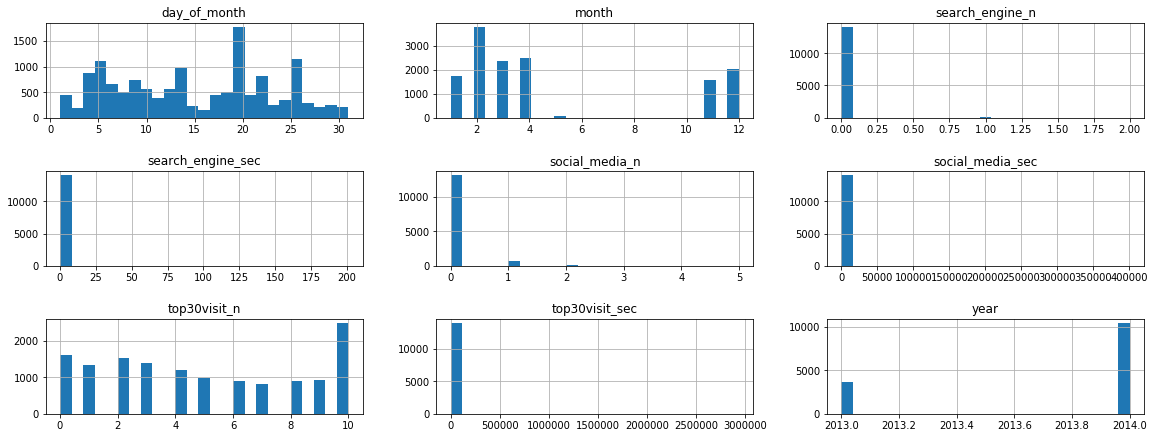

In [38]:
new_features10_un.hist(bins=25, figsize=(16,6))
plt.tight_layout(pad=0.4, w_pad=2., h_pad=2.)
plt.show()

**Года**

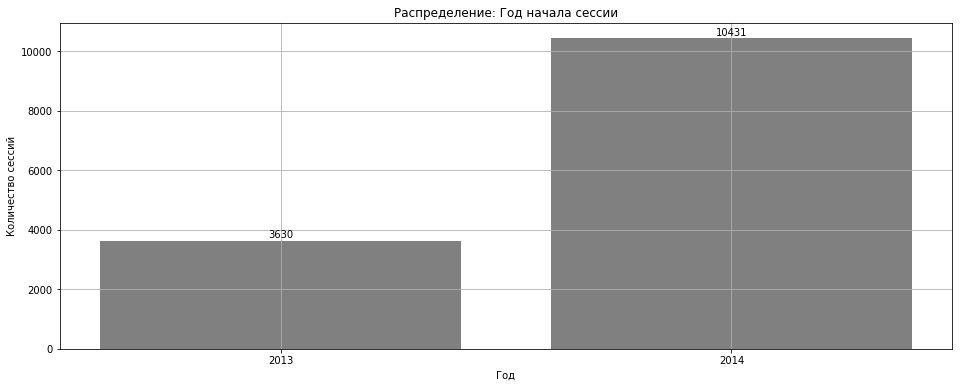

In [39]:
fig, axes = plt.subplots(figsize=(16, 6))
hst = np.histogram(new_features10_un['year'], bins=2)
labels = [2013,2014]
y_pos = [0,1]
plt.bar(y_pos, hst[0], align='center', color='grey')
plt.xticks(y_pos, labels)
plt.xlabel(u'Год')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение: '+new_features_dict['year'])
plt.grid()
for index, val in enumerate(hst[0]):
    plt.text(index, val+100, val, color='black', ha="center")
plt.show()

Распределение: Год начала сессии


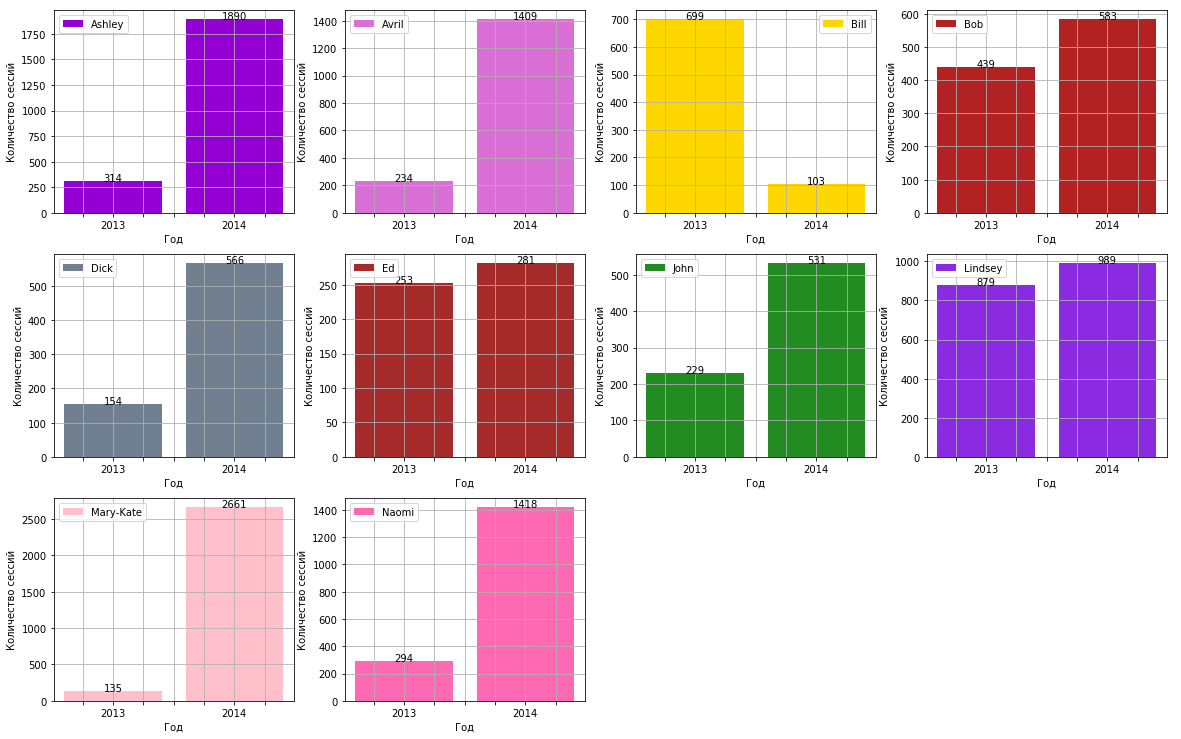

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(pad=0.4, w_pad=2., h_pad=2.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')
labels = ['','',2013,'','','',2014]
print(u'Распределение: '+new_features_dict['year'])


for idx, (user, sub_df) in enumerate(new_features10_un.groupby(by='target')):
    row = idx//4
    col = idx%4
    ax = axes[row][col]
    
    hst = np.histogram(sub_df['year'], bins=[2013,2014,2015])
    y_pos = [0,1]
    
    ax.bar(y_pos, hst[0], align='center',  color=color_dic[user], label=user)
    ax.set_xticklabels(labels)
    ax.set_xlabel(u'Год')
    ax.set_ylabel(u'Количество сессий')
    ax.legend()
    for index, val in enumerate(hst[0]):
        if(val > 0):
            ax.text(index, val, val, color='black', ha="center")
    
    ax.grid()

**Месяцы**

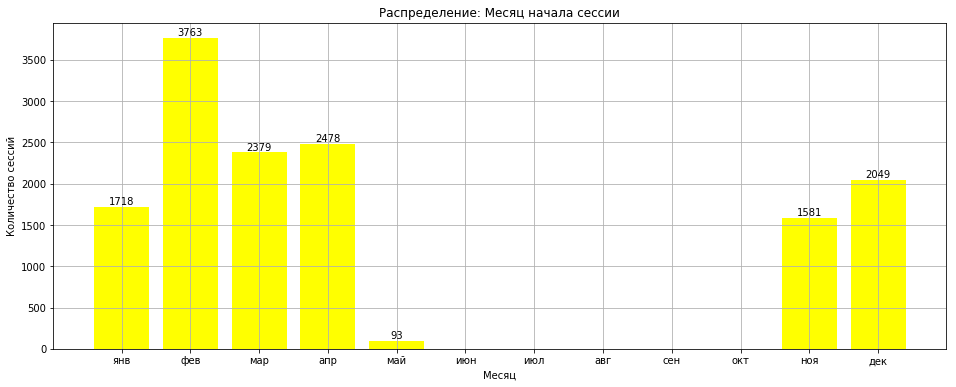

In [41]:
fig, axes = plt.subplots(figsize=(16, 6))
hst = np.histogram(new_features10_un['month'], bins=range(1,14))

labels = ['янв','фев','мар','апр','май','июн','июл','авг','сен','окт','ноя','дек']
y_pos = range(1,13)
plt.bar(y_pos, hst[0], align='center', color='yellow')
plt.xticks(y_pos, labels)
plt.xlabel(u'Месяц')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение: '+new_features_dict['month'])
plt.grid()
for index, val in enumerate(hst[0]):
    if(val>0):
        plt.text(index+1, val+30, val, color='black', ha="center")
    
plt.show()

Распределение: Месяц начала сессии


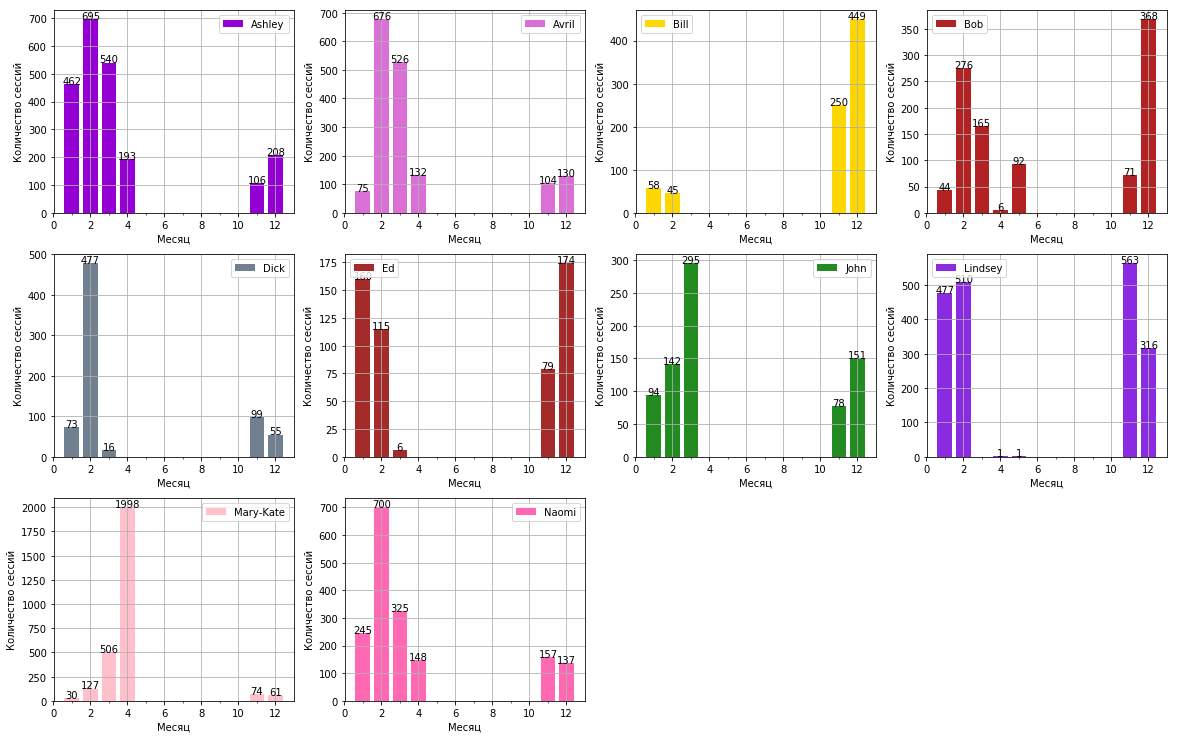

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(pad=0.4, w_pad=2., h_pad=2.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')
labels = ['', 'янв','фев','мар','апр','май','июн','июл','авг','сен','окт','ноя','дек']
print(u'Распределение: '+new_features_dict['month'])


for idx, (user, sub_df) in enumerate(new_features10_un.groupby(by='target')):
    row = idx//4
    col = idx%4
    ax = axes[row][col]
    
    hst = np.histogram(sub_df['month'], bins=range(1,14))
    y_pos = np.arange(1, len(hst[0])+1)
    
    ax.bar(y_pos, hst[0], align='center',  color=color_dic[user], label=user)
    ax.set_xticks(y_pos, labels)
    
    ax.set_xlabel(u'Месяц')
    ax.set_ylabel(u'Количество сессий')
    ax.legend()
    for index, val in enumerate(hst[0]):
        if(val > 0):
            ax.text(index+1, val, val, color='black', ha="center")
    
    ax.grid()

**Номер дня месяца**

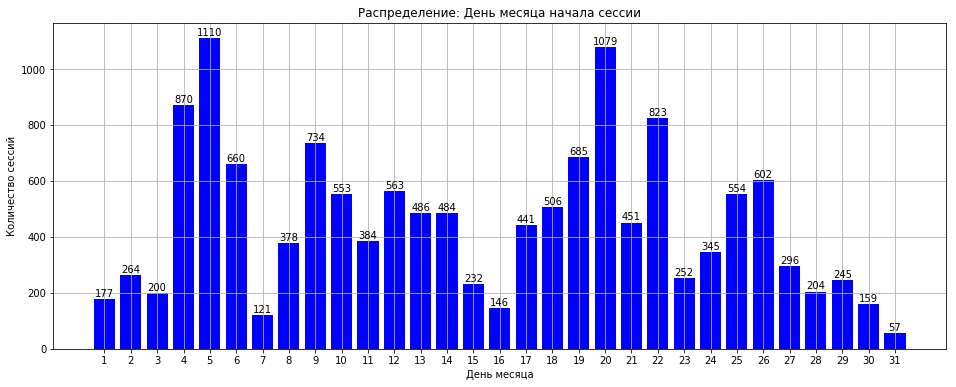

In [43]:
fig, axes = plt.subplots(figsize=(16, 6))
hst = np.histogram(new_features10_un['day_of_month'], bins=range(1,33))

labels = range(1,32)
y_pos = range(1,32)
plt.bar(y_pos, hst[0], align='center', color='blue')
plt.xticks(y_pos, labels)
plt.xlabel(u'День месяца')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение: '+new_features_dict['day_of_month'])
plt.grid()
for index, val in enumerate(hst[0]):
    if(val>0):
        plt.text(index+1, val+10, val, color='black', ha="center")
    
plt.show()

Распределение: День месяца начала сессии


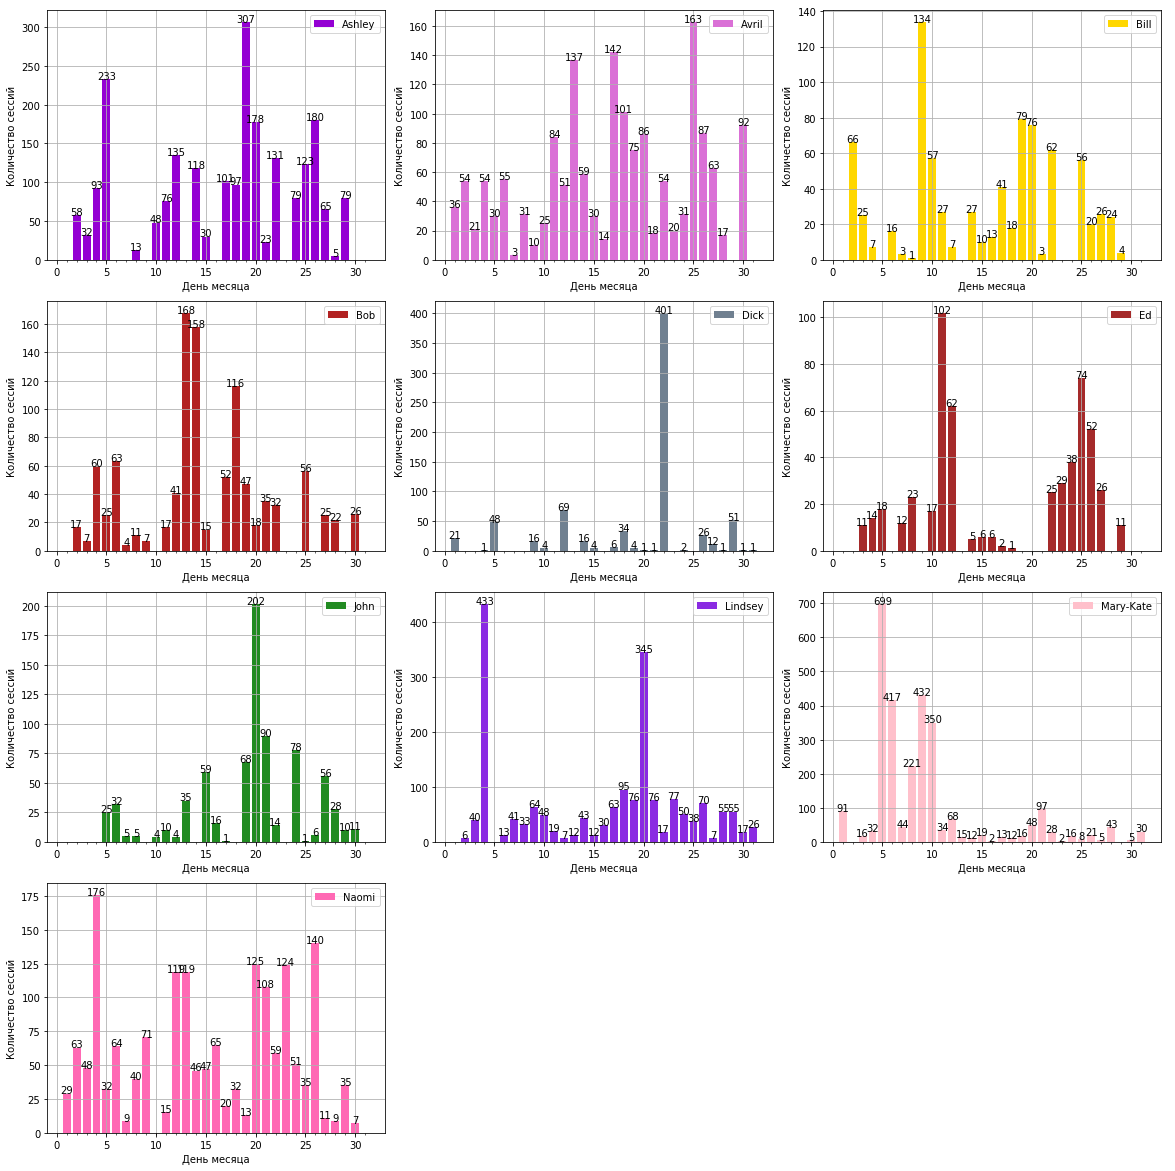

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.tight_layout(pad=0.4, w_pad=2., h_pad=2.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')
labels = range(1,32)
y_pos = range(1,32)
print(u'Распределение: '+new_features_dict['day_of_month'])


for idx, (user, sub_df) in enumerate(new_features10_un.groupby(by='target')):
    row = idx//3
    col = idx%3
    ax = axes[row][col]
    
    hst = np.histogram(sub_df['day_of_month'], bins=range(1,33))
    
    ax.bar(y_pos, hst[0], align='center',  color=color_dic[user], label=user)
    ax.set_xticks(y_pos, labels)
    
    ax.set_xlabel(u'День месяца')
    ax.set_ylabel(u'Количество сессий')
    ax.legend()
    for index, val in enumerate(hst[0]):
        if(val > 0):
            ax.text(index+1, val, val, color='black', ha="center")
    
    ax.grid()

**Час с у четом даты**

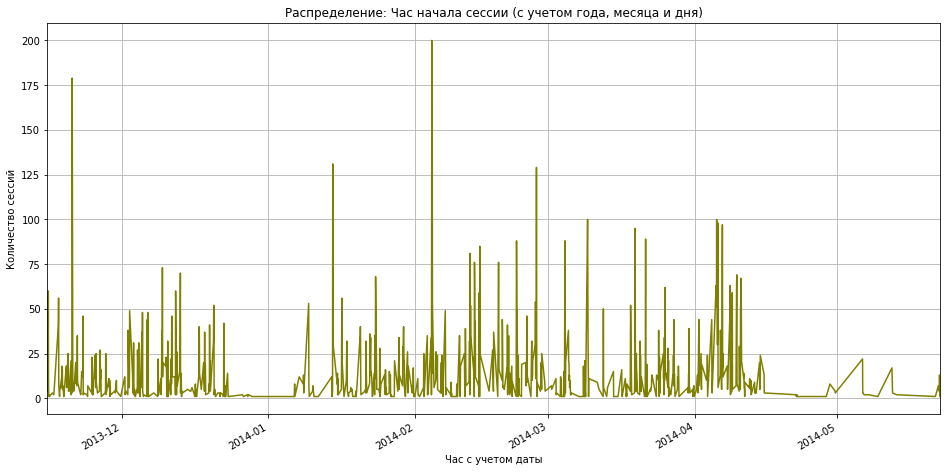

In [45]:
new_features10_un.groupby(by='hour_with_date').count().year.plot(figsize=(16,8), color='olive')
plt.grid()
plt.xlabel(u'Час с учетом даты')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение: '+new_features_dict['hour_with_date'])
pass

In [46]:
mytmp_df = new_features10_un.groupby(by=['target','hour_with_date']).count().reset_index()[['hour_with_date', 'year', 'target']]
mytmp_dc = {
    'hour_with_date' : mytmp_df.hour_with_date.values, 
    'cnt' : mytmp_df.year.values, 
    'target' : mytmp_df.target.values
    
}
exp_df = pd.DataFrame(mytmp_dc)
exp_df.head()

hour_with_date  cnt  target
0 2013-11-15 08:00:00   30  Ashley
1 2013-11-20 08:00:00   13  Ashley
2 2013-11-20 09:00:00    1  Ashley
3 2013-11-20 10:00:00    1  Ashley
4 2013-11-21 08:00:00    7  Ashley

Распределение: Час начала сессии (с учетом года, месяца и дня)


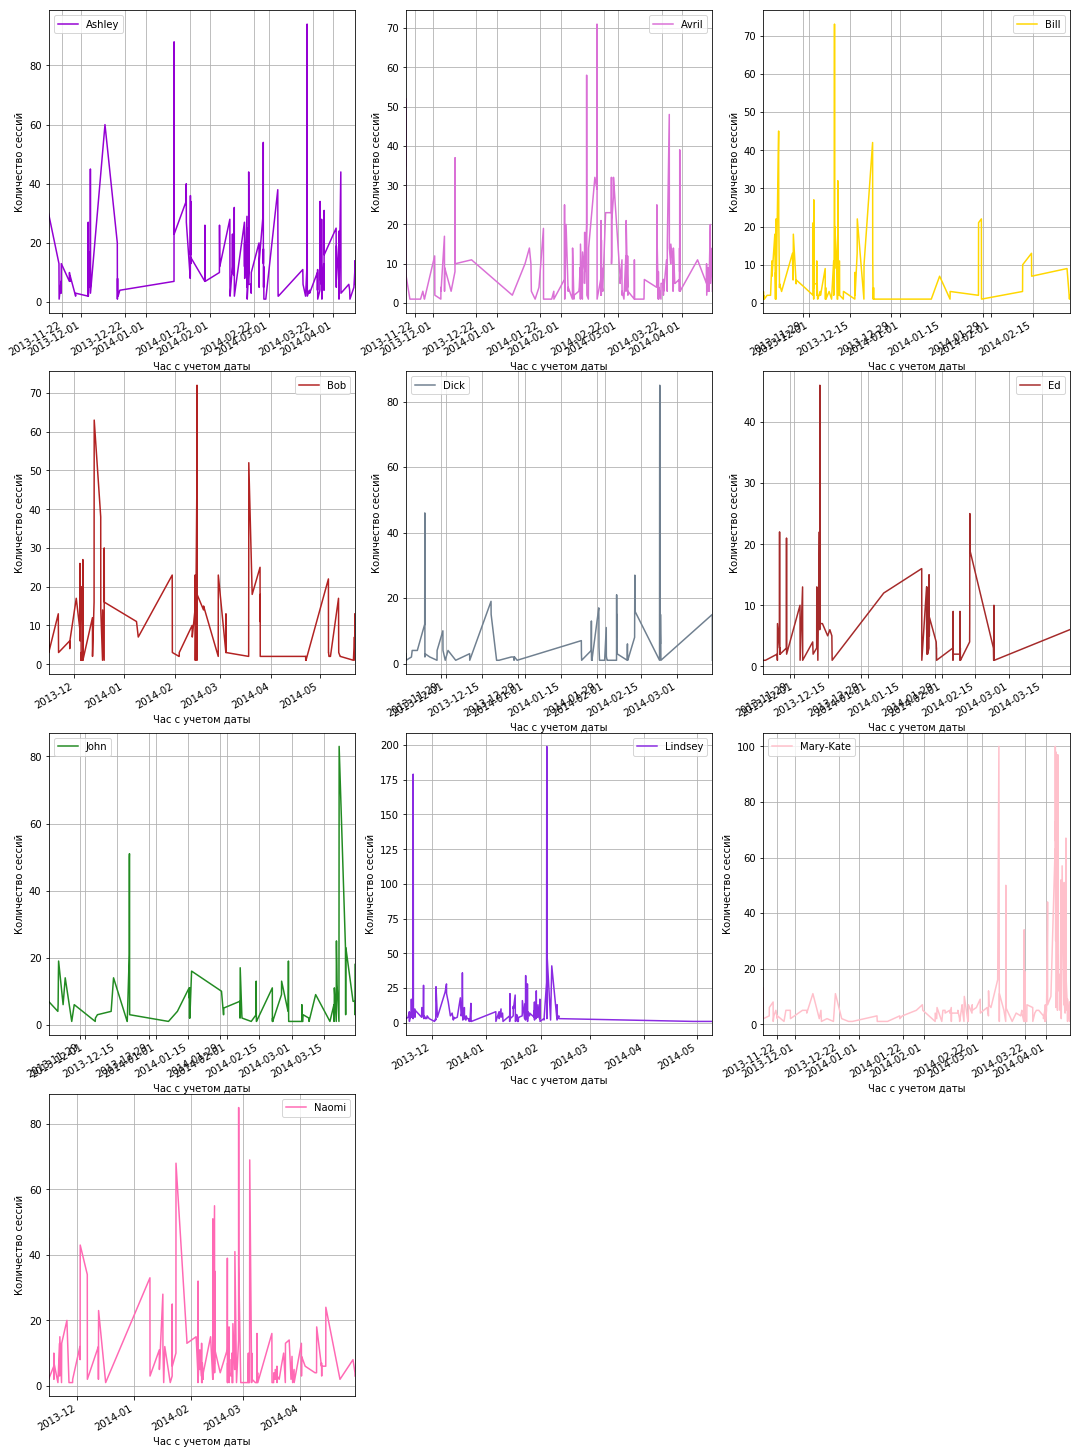

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 25))
plt.tight_layout(pad=5, w_pad=2., h_pad=5.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')

print(u'Распределение: '+new_features_dict['hour_with_date'])


for idx, (user, sub_df) in enumerate(exp_df.groupby(by='target')):
    
    row = idx//3
    col = idx%3
    ax = axes[row][col]
    
    sub_df.groupby(by='hour_with_date').sum().cnt.plot(ax = ax,  color=color_dic[user], label=user)
    
    
    
    ax.set_xlabel(u'Час с учетом даты')
    ax.set_ylabel(u'Количество сессий')
    ax.legend()
    
    ax.grid()

**Время суток**

In [48]:
mytmp_df = new_features10_un.groupby(by=['target','times_of_day']).count().reset_index()[['times_of_day', 'year', 'target']]
mytmp_dc = {
    'times_of_day' : mytmp_df.times_of_day.values, 
    'cnt' : mytmp_df.year.values, 
    'target' : mytmp_df.target.values
    
}
exp_df = pd.DataFrame(mytmp_dc)
exp_df

times_of_day   cnt     target
0            am  1565     Ashley
1            pm   639     Ashley
2            am   153      Avril
3            pm  1490      Avril
4            am   198       Bill
5            pm   604       Bill
6            am   588        Bob
7            pm   434        Bob
8            am   251       Dick
9            pm   469       Dick
10           am   100         Ed
11           pm   434         Ed
12           am   238       John
13           pm   522       John
14           am   397    Lindsey
15           pm  1471    Lindsey
16           am   571  Mary-Kate
17           pm  2225  Mary-Kate
18           am   195      Naomi
19           pm  1517      Naomi

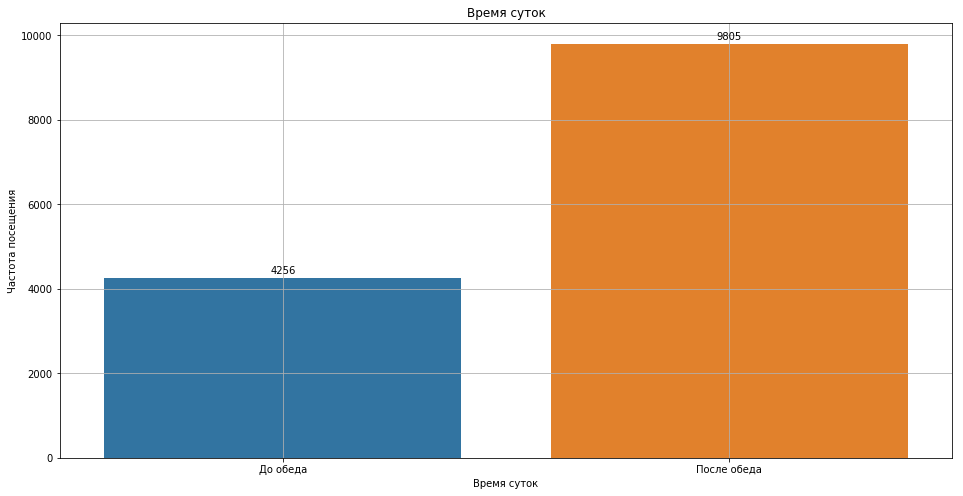

In [49]:
ttt = exp_df.groupby(by='times_of_day').sum().cnt.reset_index()
fig, ax = plt.subplots(figsize=(16,8))
g = sns.barplot(data=[[i] for i in ttt.cnt.values], ax=ax)

ax.grid()
ax.set_xticklabels([u'До обеда',u'После обеда'])
ax.set_title(new_features_dict['times_of_day'])
ax.set_xlabel(u'Время суток')
ax.set_ylabel(u'Частота посещения')

for index, val in enumerate(ttt.cnt.values):
    g.text(index, val+100, val, color='black', ha="center")

plt.show()


Распределение: Время суток


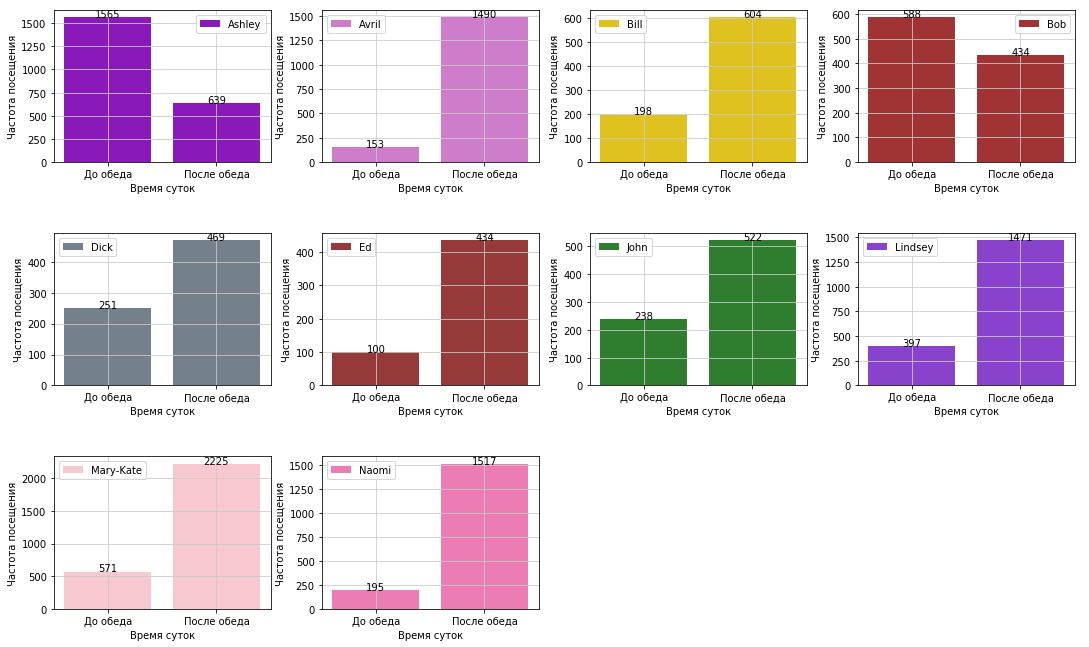

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(pad=5, w_pad=2., h_pad=5.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')

print(u'Распределение: '+new_features_dict['times_of_day'])


for idx, (user, sub_df) in enumerate(exp_df.groupby(by='target')):
    
    row = idx//4
    col = idx%4
    ax = axes[row][col]
    
    vals = [[i] for i in sub_df.cnt.values]
    g = sns.barplot(data=vals, ax=ax, color=color_dic[user], label=user)

    ax.grid()
    ax.set_xticklabels([u'До обеда',u'После обеда'])
    ax.set_xlabel(u'Время суток')
    ax.set_ylabel(u'Частота посещения')

    for index, val in enumerate(sub_df.cnt.values):
        g.text(index, val, val, color='black', ha="center")

    ax.legend()    
    ax.grid(axis='both', color="#cacaca")

**Среднее время прибывание на сайте (нули не включаются)**

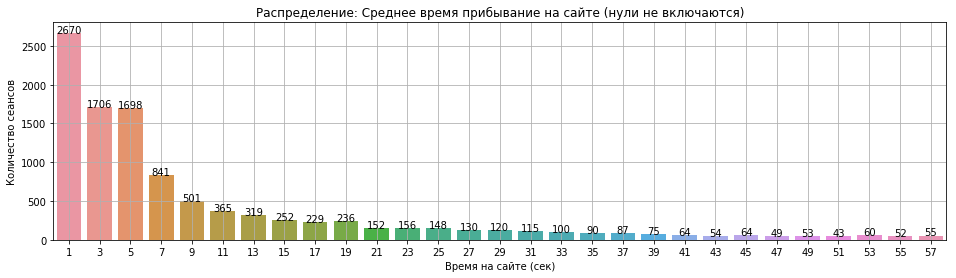

In [51]:
hst = np.histogram(new_features10_un[(new_features10_un.sess_site_time_mean <= 100) & (new_features10_un.sess_site_time_mean > 0)].sess_site_time_mean.values, bins=np.arange(1,60,2))
fig, ax = plt.subplots(figsize=(16,4))
g = sns.barplot(data=[[i] for i in hst[0]], ax=ax)
ax.grid()
ax.set_title(u'Распределение: '+new_features_dict['sess_site_time_mean'])
ax.set_xlabel(u'Время на сайте (сек)')
ax.set_ylabel(u'Количество сеансов')
ax.set_xticklabels(hst[1])
for index, val in enumerate(hst[0]):
    g.text(index, val, val, color='black', ha="center")
plt.show()

Распределение: Среднее время прибывание на сайте (нули не включаются)


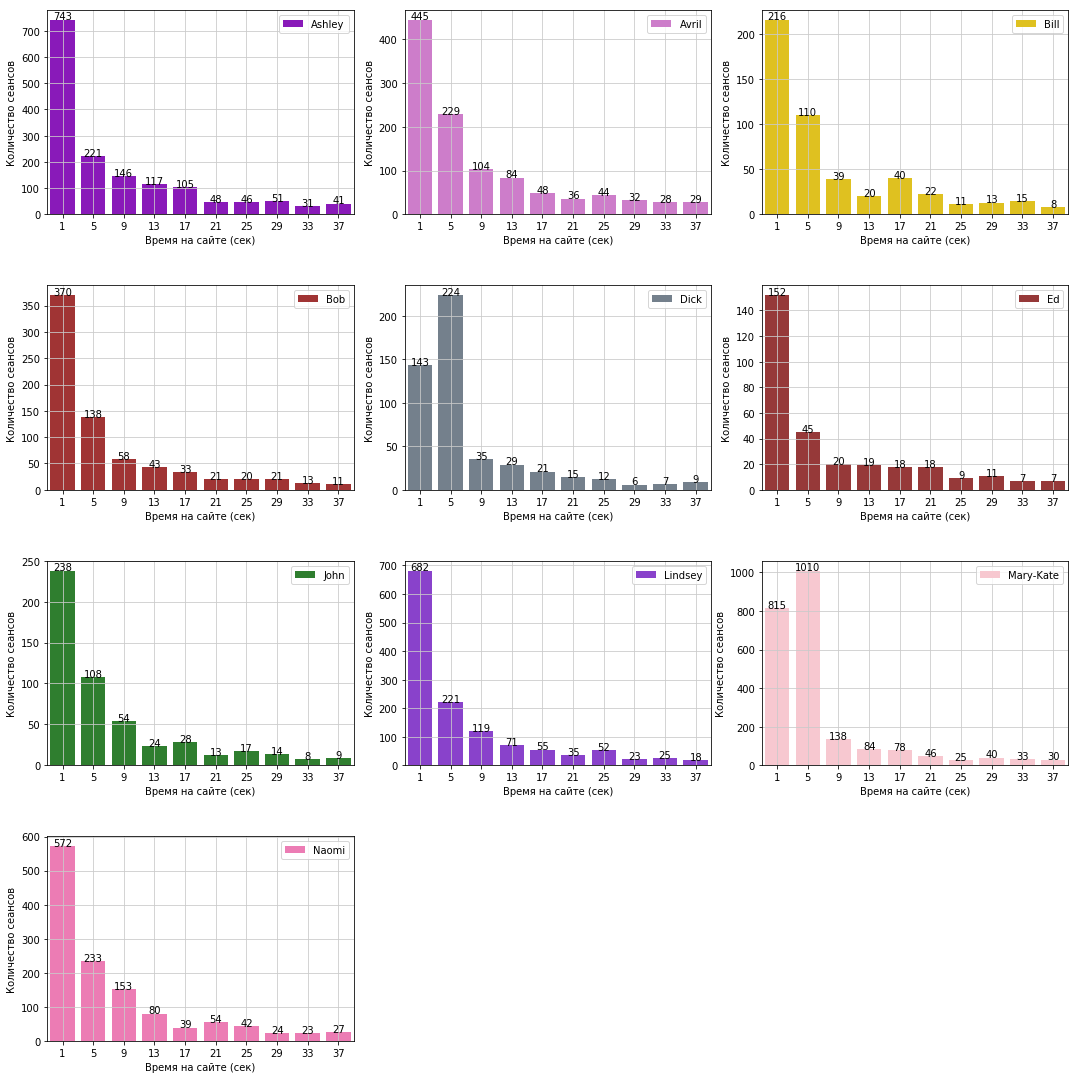

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.tight_layout(pad=5, w_pad=2., h_pad=5.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')

print(u'Распределение: '+new_features_dict['sess_site_time_mean'])


for idx, (user, sub_df) in enumerate(new_features10_un[(new_features10_un.sess_site_time_mean <= 60) & (new_features10_un.sess_site_time_mean > 0)].groupby(by='target')):
    
    row = idx//3
    col = idx%3
    ax = axes[row][col]
    hst = np.histogram(sub_df.sess_site_time_mean.values, bins=np.arange(1,44,4))
    vals = [[i] for i in hst[0]]
    g = sns.barplot(data=vals, ax=ax, color=color_dic[user], label=user)

    ax.grid()
    ax.set_xticklabels(hst[1])
    ax.set_xlabel(u'Время на сайте (сек)')
    ax.set_ylabel(u'Количество сеансов')

    for index, val in enumerate(hst[0]):
        g.text(index, val, val, color='black', ha="center")

    ax.legend()    
    ax.grid(axis='both', color="#cacaca")

**Некоторое распределение времени, проведенного на сайтах**

In [53]:
visit_n_df = new_features10_un[['top30visit_n','search_engine_n','social_media_n', 'target']]
visit_n_df.head()

top30visit_n  search_engine_n  social_media_n target
0             2                0               0   John
1             0                0               0   John
2             2                0               0   John
3             0                0               0   John
4             1                0               0   John

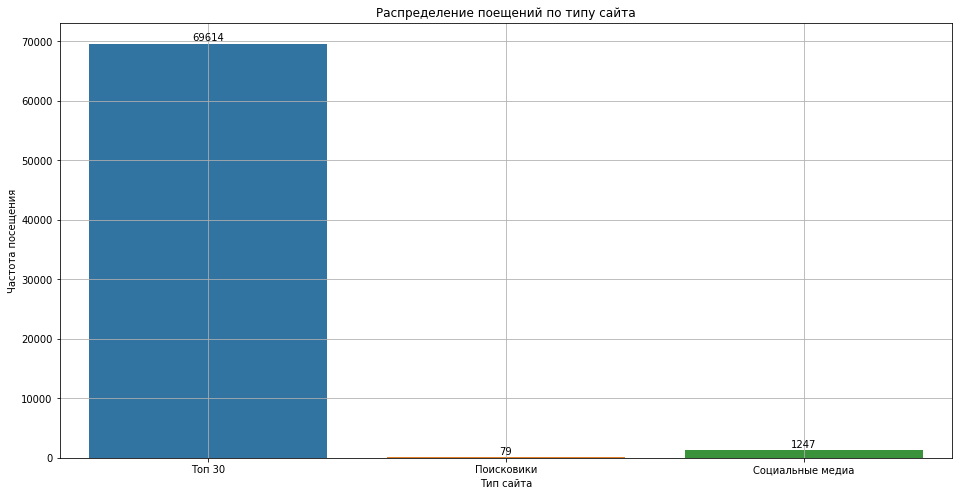

In [54]:
visit_exp_df = visit_n_df.groupby(by='target').sum().reset_index()
sm = visit_exp_df[['top30visit_n', 'search_engine_n', 'social_media_n']].sum()

fig, ax = plt.subplots(figsize=(16,8))
g = sns.barplot(data=[[i] for i in sm.values], ax=ax)

ax.grid()
ax.set_xticklabels([u'Топ 30',u'Поисковики', u'Социальные медиа'])
ax.set_title(u'Распределение поещений по типу сайта')
ax.set_xlabel(u'Тип сайта')
ax.set_ylabel(u'Частота посещения')
for index, val in enumerate(sm.values):
    g.text(index, val+500, val, color='black', ha="center")
plt.show()

Распределение посещений по типу сайта


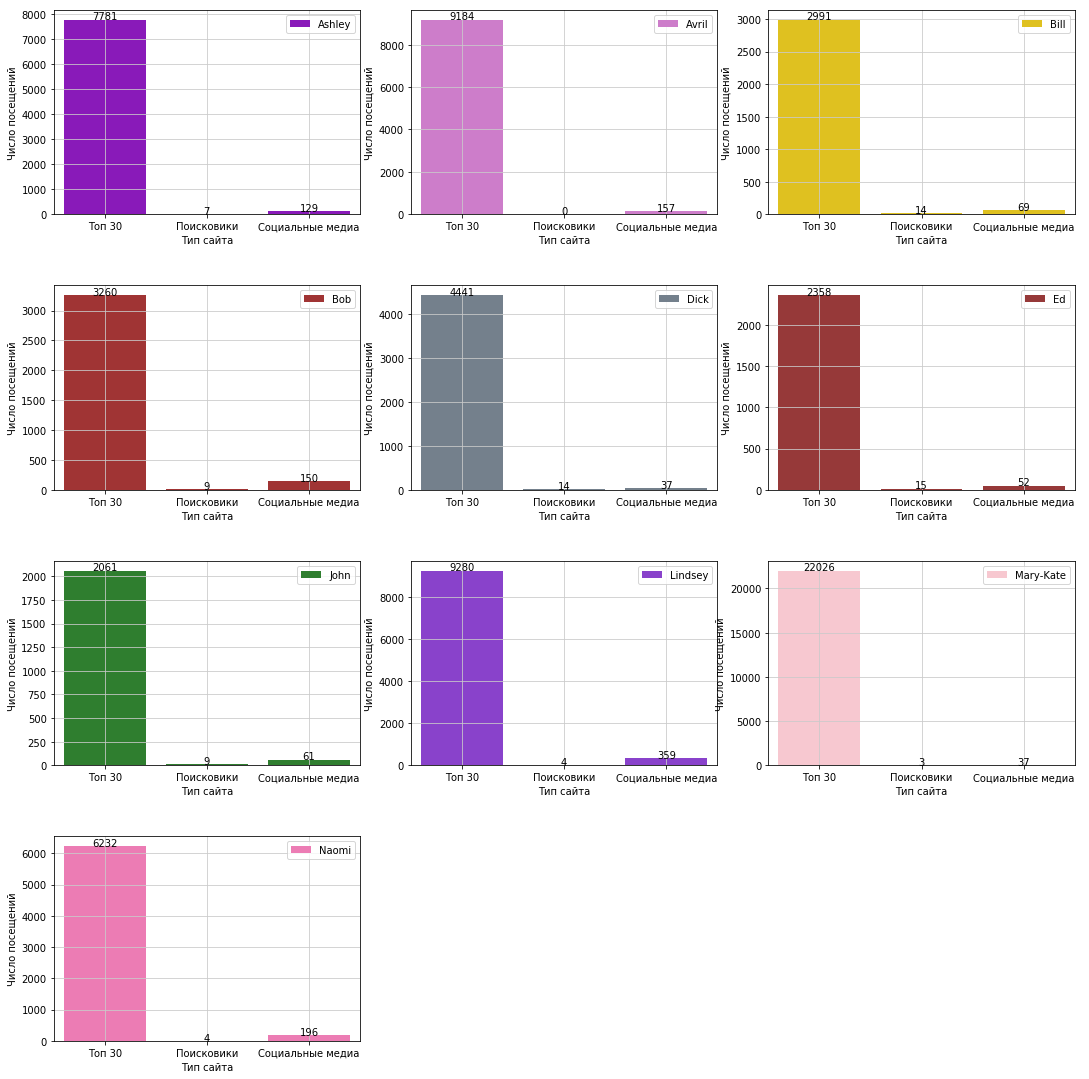

In [55]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.tight_layout(pad=5, w_pad=2., h_pad=5.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')

print(u'Распределение посещений по типу сайта')


for idx, (user, sub_df) in enumerate(visit_exp_df.groupby(by='target')):
    
    row = idx//3
    col = idx%3
    ax = axes[row][col]
   
    vals = [[sub_df.top30visit_n.values[0]], [sub_df.search_engine_n.values[0]], [sub_df.social_media_n.values[0]]]

    g = sns.barplot(data=vals, ax=ax, color=color_dic[user], label=user)

    ax.grid()
    ax.set_xticklabels([u'Топ 30',u'Поисковики', u'Социальные медиа'])
    ax.set_xlabel(u'Тип сайта')
    ax.set_ylabel(u'Число посещений')

    for index, val in enumerate(vals):
        g.text(index, val[0], val[0], color='black', ha="center")

    ax.legend()    
    ax.grid(axis='both', color="#cacaca")

**Суммарное время по типу сайтов**

In [56]:
visit_sec_df = new_features10_un[['top30visit_sec','search_engine_sec','social_media_sec', 'target']].groupby(by='target').sum().reset_index()
visit_sec_df

target  top30visit_sec  search_engine_sec  social_media_sec
0     Ashley         3597811                 16             26753
1      Avril         9511358                  0            155787
2       Bill         3316223                 75             15141
3        Bob         2095256                112            403062
4       Dick         3190031                 25              1114
5         Ed         6497608                213               966
6       John         2725623                  9               685
7    Lindsey         4045371                  1              8783
8  Mary-Kate         4051281                  0              1476
9      Naomi         4864295                  0            189008

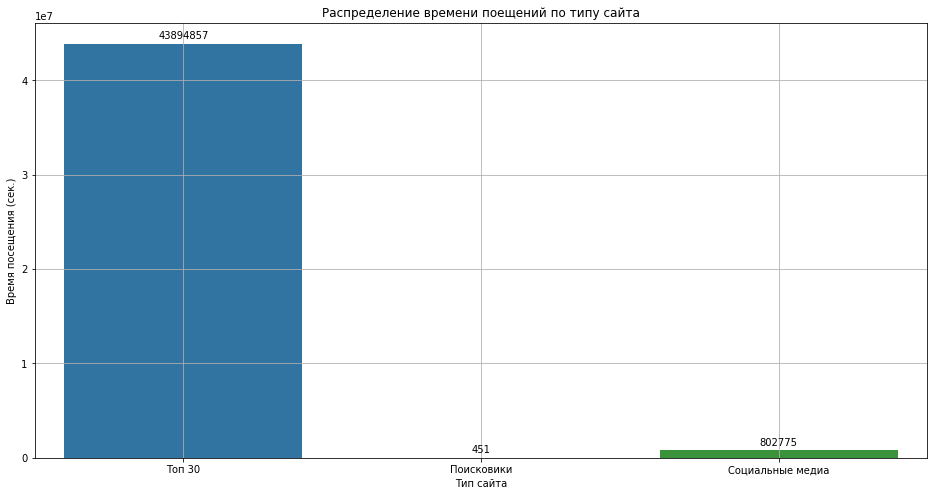

In [57]:
sm = visit_sec_df[['top30visit_sec','search_engine_sec','social_media_sec']].sum()


fig, ax = plt.subplots(figsize=(16,8))
g = sns.barplot(data=[[i] for i in sm.values], ax=ax)

ax.grid()
ax.set_xticklabels([u'Топ 30',u'Поисковики', u'Социальные медиа'])
ax.set_title(u'Распределение времени поещений по типу сайта')
ax.set_xlabel(u'Тип сайта')
ax.set_ylabel(u'Время посещения (сек.)')
for index, val in enumerate(sm.values):
    g.text(index, val+500000, val, color='black', ha="center")
plt.show()

Распределение времени посещений по типу сайта


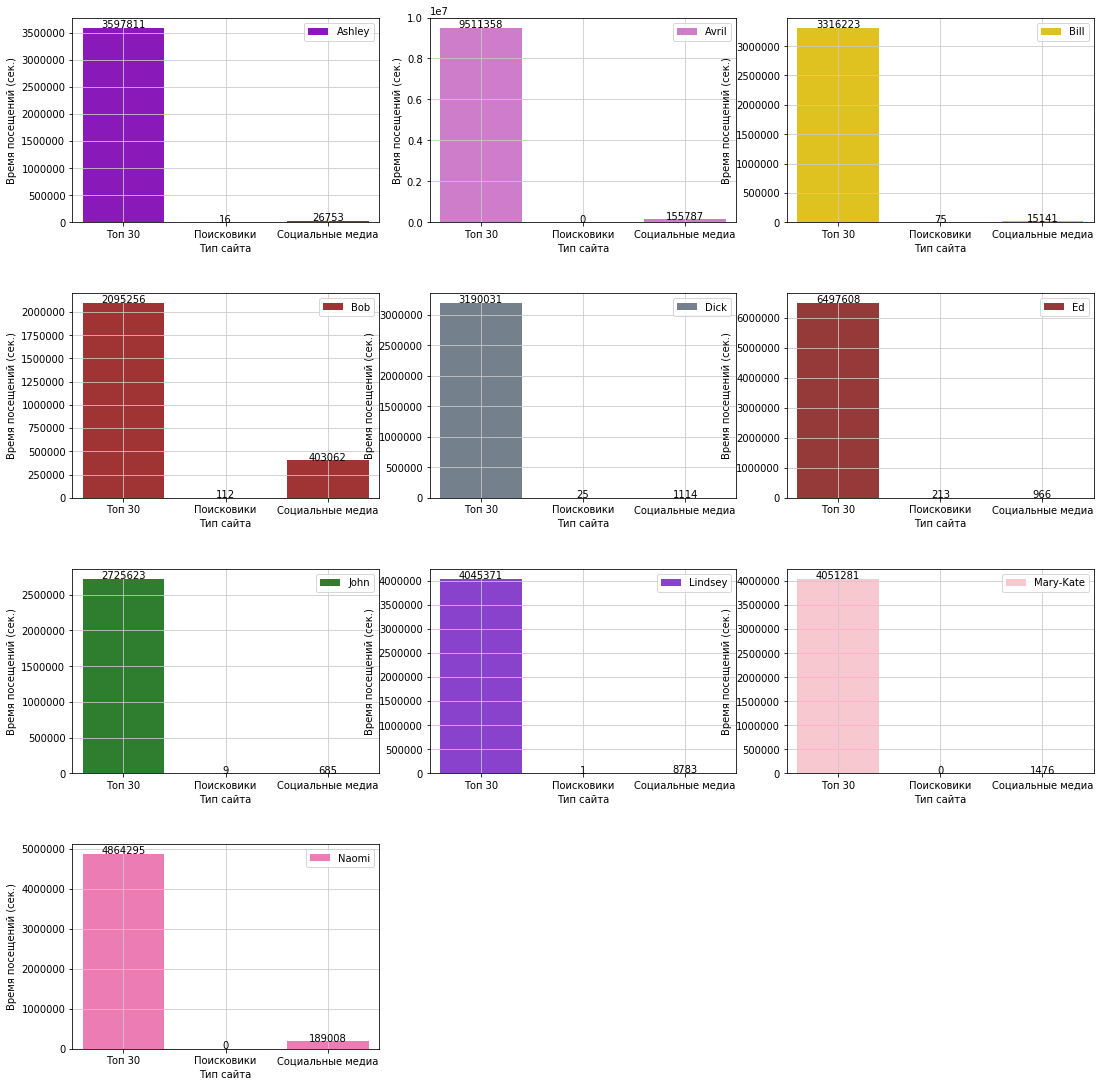

In [58]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.tight_layout(pad=5, w_pad=2., h_pad=5.)
axes[-1, -1].axis('off');axes[-1, -2].axis('off')

print(u'Распределение времени посещений по типу сайта')


for idx, (user, sub_df) in enumerate(visit_sec_df.groupby(by='target')):
    
    row = idx//3
    col = idx%3
    ax = axes[row][col]
   
    vals = [[sub_df.top30visit_sec.values[0]], [sub_df.search_engine_sec.values[0]], [sub_df.social_media_sec.values[0]]]

    g = sns.barplot(data=vals, ax=ax, color=color_dic[user], label=user)

    ax.grid()
    ax.set_xticklabels([u'Топ 30',u'Поисковики', u'Социальные медиа'])
    ax.set_xlabel(u'Тип сайта')
    ax.set_ylabel(u'Время посещений (сек.)')

    for index, val in enumerate(vals):
        g.text(index, val[0], val[0], color='black', ha="center")

    ax.legend()    
    ax.grid(axis='both', color="#cacaca")

## Комментарии по новым признакам
**Все добавленные новые признаки таки или иначе позволяют идентифицировать пользователей, это видно из построенной визуализации**


1. Распределеник по годам указывает, что ппроявлять активнсть они начали в разные года. Во сновном максимальная активность наблюдается для пользователей в 2014 году, кроме Bill, Bob, Ed, Lindsey, где наблюдается значительная ативность в 2013 году
2. По месяцу начала сессии так или наче наблюдается незатронутым летний период (активность отсутствует практически у всех пользователей), но в активнные периоды наблюдается различие в активности

|Пользователь|Месяц активности| 
|----|----|
|Ashley|	Февраль
|Avril|	Февраль
|Bill|	Декабрь
|Bob|	Декабрь
|Dick|	Февраль
|Ed|	Декабрь
|John|	Март
|Lindsey|	Ноябрь
|Mary-Kate|	Апрель
|Naomi|	Февраль

3. Номер дня месяца также неплохо идентифицирует пользователя, у всех пользователлей наблюдаются индифидуальные гистограммы, что можно сазатьи о часе с учеиом даты
4. По времени суток пользователи хорошо разделимы на сов и жаворонков

|Пользователь|	Тип активности по времени суток|
|---|---|
|Ashley|	Жаворонок
|Avril|	Сова
|Bill|	Сова
|Bob|	Примерно пополам
|Dick|	Сова
|Ed|	Сова
|John|	Сова
|Lindsey|	Сова
|Mary-Kate|	Сова
|Naomi|	Сова

5. К сожалению фича "Среднее время прибывание на сайте (нули не включаются)" не дала слишком ярких отличий
6. Но тем не менее по контенту (например зависимость от социальных медя, мы видим некоторую зависомость или деление на группы)

**Наверное неплохо подойдут инструменты (для посроения классификаторов) и использованием рекурентных нейронных сетей для запоминания последовательности посещения сайтов (по аналогии с текстами) или инструменты с использованием мешка сайтов. Неплохо бы в начале провести кластеризацию сайтов, чтобы разделить их на семантические группы и посмотреть на семантику пользователей (интересы).**



**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [59]:
selected_features_150users = pd.merge(train_data_150users, new_features_150users, left_index=True, right_index=True)
selected_features_10users = pd.merge(train_data_10users, new_features_10users, left_index=True, right_index=True)

In [60]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 